# Solving Krusell Smith Model with HARK and SSJ

By William Du

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from sequence_jacobian import create_model, simple  # functions
from sequence_jacobian.classes import JacobianDict, SteadyStateDict

from HARK.ConsumptionSaving.ConsNewKeynesianModel import NewKeynesianConsumerType

# Calibration and setup

This notebook uses the HARK toolkit to solve [Krusell and Smith (1998)](https://www.journals.uchicago.edu/doi/abs/10.1086/250034), applying the [Sequence Space Jacobian](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17434) and [SSJ toolkit](https://github.com/shade-econ/sequence-jacobian). 

## Firm setup

Collect calibration for the production economy in a dictionary.

In [2]:
calibration = {
    "eis": 1,  # Elasticity of intertemporal substitution
    "delta": 0.025,  # Depreciation rate
    "alpha": 0.11,  # Capital share of income
    "L_ss": 1.0,  # Steady state labor
    "Y_ss": 1.0,  # Steady state output
    "r_ss": 0.01,  # Steady state real interest rate
}

### Steady State Capital 

Find steady state capital (`K_ss`) and productivity  (`Z`) implied by the firm's first order condition, aggregate resource constraint and the above steady state values of labor (`L_ss`), the real interest rate (`r_ss`) and output (`Y_ss`). 

In [3]:
from scipy.optimize import root


def your_funcs(X):
    L_ss = calibration["L_ss"]
    alpha = calibration["alpha"]
    delta = calibration["delta"]
    r_ss = calibration["r_ss"]
    Y_ss = calibration["Y_ss"]

    K, Z = X

    # Firms first order condition and aggregate resource constraint
    f = [
        alpha * Z * (K / L_ss) ** (alpha - 1) - delta - r_ss,  # r_ss = MPK
        Z * K**alpha * L_ss ** (1 - alpha) - Y_ss,  # Y = Z*F(K,L)
    ]

    return f


sol = root(your_funcs, [1.0, 1.0])  # find roots

K_ss, Z_ss = sol.x

calibration["K_ss"] = K_ss
calibration["Z_ss"] = Z_ss

In [4]:
print(sol)

 message: The solution converged.
 success: True
  status: 1
     fun: [ 1.749e-14 -5.218e-15]
       x: [ 3.143e+00  8.816e-01]
  method: hybr
    nfev: 16
    fjac: [[-3.675e-01  9.300e-01]
           [-9.300e-01 -3.675e-01]]
       r: [ 3.906e-02  1.143e+00 -3.236e-01]
     qtf: [-4.533e-12 -5.621e-12]


Double check the roots we find produce our chosen steady state values. 

In [5]:
def firm(
    K,
    Z,
    L_ss=calibration["L_ss"],
    alpha=calibration["alpha"],
    delta=calibration["delta"],
):
    r = alpha * Z * (K / L_ss) ** (alpha - 1) - delta
    w = (1 - alpha) * Z * (K / L_ss) ** alpha
    Y = Z * K**alpha * L_ss ** (1 - alpha)
    return r, w, Y


r_ss, w_ss, Y_ss = firm(sol.x[0], sol.x[1])

calibration["w_ss"] = w_ss

In [6]:
print("--------------------------------------+------------")
print(f"Steady state capital                  | {K_ss:.4f}")
print(f"Steady state output                   | {Y_ss:.4f}")
print(f"Steady state real interest rate       | {r_ss:.4f}")
print(f"Steady state wage                     | {w_ss:.4f}")
print("--------------------------------------+------------")

--------------------------------------+------------
Steady state capital                  | 3.1429
Steady state output                   | 1.0000
Steady state real interest rate       | 0.0100
Steady state wage                     | 0.8900
--------------------------------------+------------


## HARK agent

HARK represents agent problems where aggregate variables can affect an individual income process as instances of `NewKeynesianConsumerType`, a subclass of `AgentType` (see [A Gentle Introduction to HARK](https://docs.econ-ark.org/examples/Gentle-Intro/Gentle-Intro-To-HARK.html)).

Instances of the `NewKeynesianConsumerType` class contain functions that solve policy functions of optimizing agents and compute Jacobian matrices in response to a policy shocks using the [SSJ toolkit](https://github.com/shade-econ/sequence-jacobian). 

**_NOTE:_**  `NewKeynesianConsumerType` is still a microeconomic agent solving an income fluctuation problem. The only difference from [`IndShockConsumerType`](https://docs.econ-ark.org/examples/HowWeSolveIndShockConsumerType/HowWeSolveIndShockConsumerType.html) is that additional aggregate labour income variables are passed to the agent's income process. This allows the agent's problem to be defined within a general equilibrium framework such as (but not restricted to) HANK. 

**_NOTE:_** Researchers can also create their own agent types by subclassing `AgentType`. See [HARK's documentation](https://docs.econ-ark.org/examples/HowWeSolveIndShockConsumerType/HowWeSolveIndShockConsumerType.html) for more information.

To create an instance of `NewKeynesianConsumerType`, first specify parameters in a dictionary. To start, we use a discount factor of 0.98.

In [7]:
L_ss = calibration["L_ss"]
w_ss = calibration["w_ss"]
r_ss = calibration["r_ss"]

HANK_Dict = {
    # Individual agent 'preferences' (shared with perfect foresight model)
    "CRRA": calibration["eis"],  # Coefficient of relative risk aversion
    "DiscFac": 0.98,  # Intertemporal discount factor
    "LivPrb": [0.99375],  # Survival probability
    # Individual lifcycle income process parameters
    "PermGroFac": [1.00],  # Permanent income growth factor
    "PermShkStd": [0.06],  # Standard deviation of log permanent shocks to income
    "PermShkCount": 5,  # Number of points in discrete approximation to permanent income shocks
    "TranShkStd": [0.2],  # Standard deviation of log transitory shocks to income
    "TranShkCount": 5,  # Number of points in discrete approximation to transitory income shocks
    # Parameters related to unemployment and retirement
    "UnempPrb": 0.0,  # Probability of unemployment while working
    "IncUnemp": 0.0,  # Unemployment benefits replacement rate
    "UnempPrbRet": 0.0000,  # Probability of "unemployment" while retired
    "IncUnempRet": 0.0,  # "Unemployment" benefits when retired
    "T_retire": 0.0,  # Period of retirement (0 --> no retirement)
    # Aggregates affecting the agent's decision
    "Rfree": [(1 + r_ss)],  # Interest factor for assets faced by agents
    "wage": [w_ss],  # Wage rate faced by agents
    "tax_rate": [
        0
    ],  # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [L_ss],  # Aggregate (mean) labor supply
    # Parameters for constructing "assets above minimum" grid
    "aXtraMin": 0.0001,  # Minimum end-of-period "assets above minimum" value
    "aXtraMax": 2000,  # Maximum end-of-period "assets above minimum" value
    "aXtraCount": 200,  # Number of points in the base grid of "assets above minimum"
    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraNestFac": 3,
    "aXtraExtra": None,  # Additional values to add to aXtraGrid
    # Transition matrix simulation parameters
    "mCount": 200,
    "mMax": 2000,
    "mMin": 0.0001,
    "mFac": 3,
}

Let's create a temporary instance of a `NewKeynesianConsumerType` agent.

In [8]:
tempAgent = NewKeynesianConsumerType(**HANK_Dict)

Given a discount factor, the agent will supply a steady state capital stock `A_ss`.

In [9]:
A_ss = tempAgent.compute_pe_steady_state()[0]
print(f"Steady state agent asset supply for beta = 0.98 is: {A_ss:.3f}")

Steady state agent asset supply for beta = 0.98 is: 0.231


### Steady State Assets 

Since we are interested in computing a steady state equilibrium, we find `discFac` such that `A_ss`  clears the asset market given that `K_ss` is the steady state firm capital demand. 

In [10]:
def A_ss_func(beta):
    HANK_Dict["DiscFac"] = beta

    # For a given value of beta, we need to re-create the Agent
    Agent_func = NewKeynesianConsumerType(**HANK_Dict, verbose=False)

    # And then solve for the steady state supply
    A_ss = Agent_func.compute_pe_steady_state()[0]

    return A_ss


def ss_dif(beta):
    return A_ss_func(beta) - Asset_target


start = time.time()
Asset_target = K_ss

DiscFac = optimize.brentq(ss_dif, 0.8, 0.9999)

print(f"Time taken to solve for steady state {time.time() - start:.3f} secs.")

Time taken to solve for steady state 12.110 secs.


We can now create the steady state agent using the general equilibrium discount factor.

In [11]:
# Create a new agent
HANK_Dict["DiscFac"] = DiscFac
steadyHANK = NewKeynesianConsumerType(**HANK_Dict, verbose=False)
A_ss, C_ss = steadyHANK.compute_pe_steady_state()

In [12]:
# To make sure goods and asset markets clear
print(
    "Final goods clearing:",
    calibration["Y_ss"] - C_ss - calibration["delta"] * calibration["K_ss"],
)
print("Asset clearing:", A_ss - calibration["K_ss"])

Final goods clearing: 0.019151809710783327
Asset clearing: -4.278883913855225e-10


# Computing Jacobians using SSJ

With the steady state agent in hand, we can compute the Jacobians of the steady state HANK agent's policy with respect to the aggregate state variables.

The `calc_jacobian` method of our `NewKeynesianConsumerType` agent computes the Jacobians of the steady state aggregate consumption (`CJACW`) and assets (`AJACW`) with respect to a pertubation of a specified variable.

Recall `CJACW[s,t]` is the time $t$ response to a shock at time $s$. 

Here is an example where we shock the wage rate. 

In [13]:
start = time.time()

CJACW, AJACW = steadyHANK.calc_jacobian("wage", 300)  # Wage jacobians

print(f"Time taken to compute wage Jacobians: {time.time() - start:.3f} seconds")

Time taken to compute wage Jacobians: 4.183 seconds


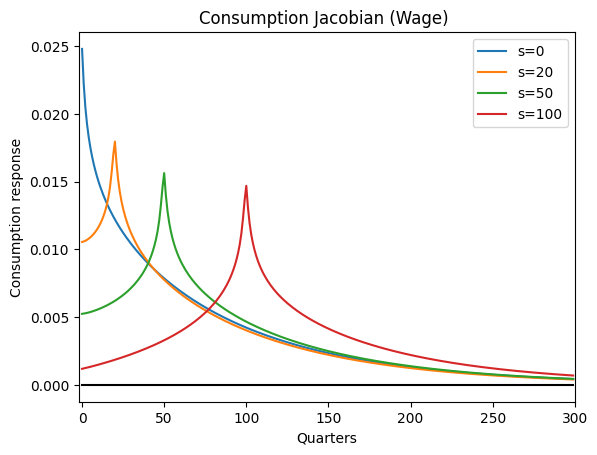

In [14]:
plt.plot(CJACW.T[0], label="s=0")
plt.plot(CJACW.T[20], label="s=20")
plt.plot(CJACW.T[50], label="s=50")
plt.plot(CJACW.T[100], label="s=100")
plt.xlim(-2, 300)
plt.plot(np.arange(300), np.zeros(300), color="k")
plt.title("Consumption Jacobian (Wage) ")
plt.xlabel("Quarters")
plt.ylabel("Consumption response")
plt.legend()
plt.show()

In [15]:
start = time.time()

CJACR, AJACR = steadyHANK.calc_jacobian("Rfree", 300)  # Rfree jacobians

print(
    f"Time taken to compute return factor Jacobians: {time.time() - start:.3f} seconds"
)

Time taken to compute return factor Jacobians: 4.376 seconds


Here is an example where we shock the return factor. 

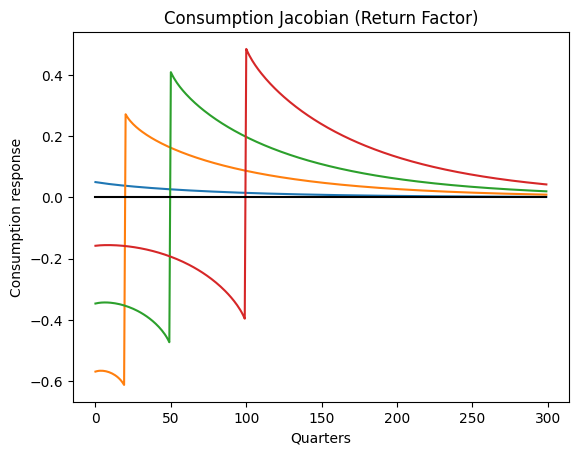

In [16]:
plt.plot(CJACR.T[0], label="s =0")
plt.plot(CJACR.T[20], label="s=20")
plt.plot(CJACR.T[50], label="s=50")
plt.plot(CJACR.T[100], label="s=100")
plt.plot(np.arange(300), np.zeros(300), color="k")
plt.title("Consumption Jacobian (Return Factor)")
plt.xlabel("Quarters")
plt.ylabel("Consumption response")
plt.show()

Let's store the Jacobians in a dictionary for later use.

In [17]:
# Store Jacobians in JacobianDict Object
Jacobian_Dict = JacobianDict(
    {
        "C": {
            "w": CJACW,
            "r": CJACR,
        },
        "A": {
            "w": AJACW,
            "r": AJACR,
        },
    },
)

# Construct SteadyStateDict object
SteadyState_Dict = SteadyStateDict(
    {
        "asset_mkt": 0.0,
        "goods_mkt": 0.0,
        "r": r_ss,
        "Y": Y_ss,
        "A": K_ss,
        "C": C_ss,
        "Z": Z_ss,
        "delta": calibration["delta"],
        "alpha": calibration["alpha"],
        "L": L_ss,
        "K": K_ss,
        "w": w_ss,
    },
)

## Impulse Response Functions and Simulations 

In [18]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha - 1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y


@simple
def mkt_clearing(K, A, Y, C, delta):
    asset_mkt = A - K
    goods_mkt = Y - C - delta * K
    return asset_mkt, goods_mkt

In [19]:
ks = create_model([Jacobian_Dict, firm, mkt_clearing], name="Krusell-Smith")

### Solving for Impulse Responses

In [20]:
T = 300  # Length of the IRF
rho_Z = 0.8  # Persistence of IRF shock
dZ = 0.001 * Z_ss * rho_Z ** np.arange(T)
shocks = {"Z": dZ}

inputs = ["Z"]
unknowns = ["K"]
targets = ["asset_mkt"]

irfs_Z = ks.solve_impulse_linear(SteadyState_Dict, unknowns, targets, shocks)

In [21]:
def show_irfs(
    irfs_list,
    variables,
    labels=[" "],
    ylabel=r"Percentage point (dev. from ss)",
    T_plot=50,
    figsize=(18, 6),
):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(irf[variables[i]][:50] * 1e2, label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"Quarters")
        if i == 0:
            ax[i].set_ylabel(ylabel)
        # ax[i].legend()
        # ax[i].x

    plt.tight_layout()
    plt.show()
    # plt.savefig("irf.png")

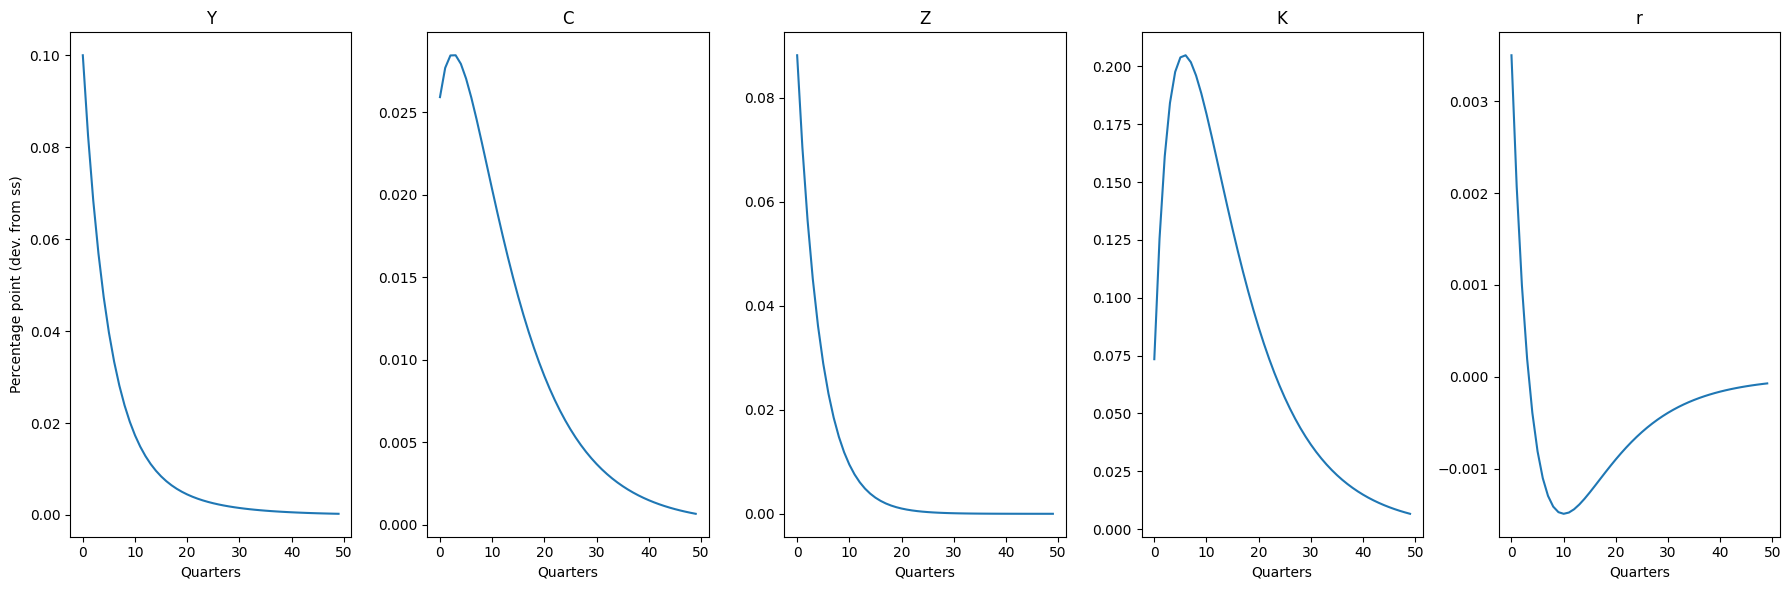

In [22]:
# Impulse Responses to Productivity Shock
show_irfs([irfs_Z], ["Y", "C", "Z", "K", "r"])

### Simulating the model

In [23]:
from estimation.plots import plot_timeseries
from estimation.routines import simulate

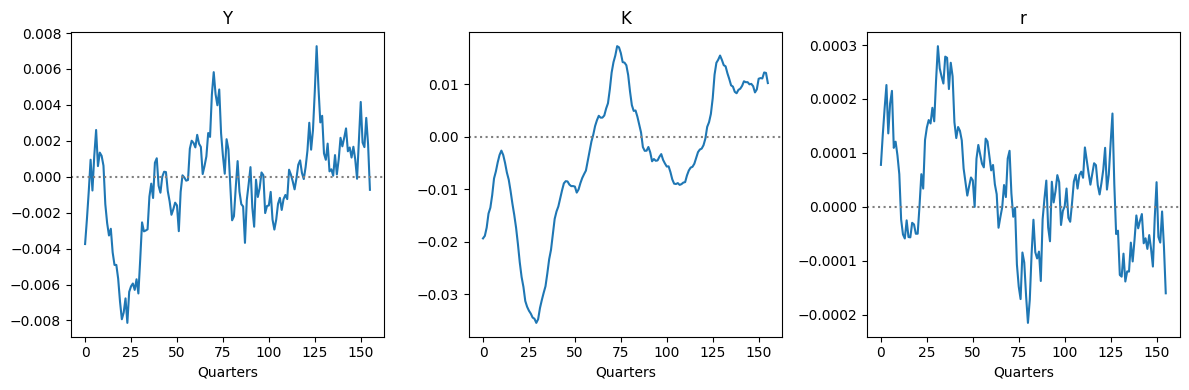

In [24]:
outputs = ["Y", "K", "r"]

sigmas = {"Z": 0.001}
rhos = {"Z": 0.8}
impulses = {}

for i in inputs:
    own_shock = {i: sigmas[i] * rhos[i] ** np.arange(T)}
    impulses[i] = ks.solve_impulse_linear(
        SteadyState_Dict,
        unknowns,
        targets,
        own_shock,
    )


T_sim = 156  # 39 years, as in the original SW (2007) sample
data_simul = simulate(list(impulses.values()), outputs, T_sim)
plot_timeseries(data_simul, (1, 3), figsize=(12, 4))